In [1]:
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
from tqdm import tqdm

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/arcadia/.local/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/arcadia/.local/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/arcadia/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/home/arcadia/.local/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/home/arcadia/.local/lib/python3.9/site-packages/traitlets/traitlets.py", line 649, in get
    value = self._validate(obj, default)
  File "/home/arcadia/.local/lib/pytho

In [2]:
BASE_PATH = "data_2/"

X_INIT = 45_910
step_x = 2

In [15]:
def get_data(power, idx):
    converted_path = os.path.join(BASE_PATH, f"run_Power_{power}%", "converted")
    converted_files = glob.glob(os.path.join(converted_path, "*.root"))
    sorted_files = sorted(
            converted_files,
            key=lambda path: int(re.search(r'run(\d+)\.root', path).group(1))
        )
    data_path = sorted_files[idx]
    

    with ur.open(data_path) as data_file:
        data = data_file["pulse"]
        out_data = data.arrays(["channel"], library="np")
        time = data.arrays(["time"], library="np")
    
    return out_data, time

NameError: name 'time' is not defined

In [16]:
power = 80.0
idx = 0
out_data, time = get_data(power, idx)

In [28]:
t = time["time"][0,0,:]

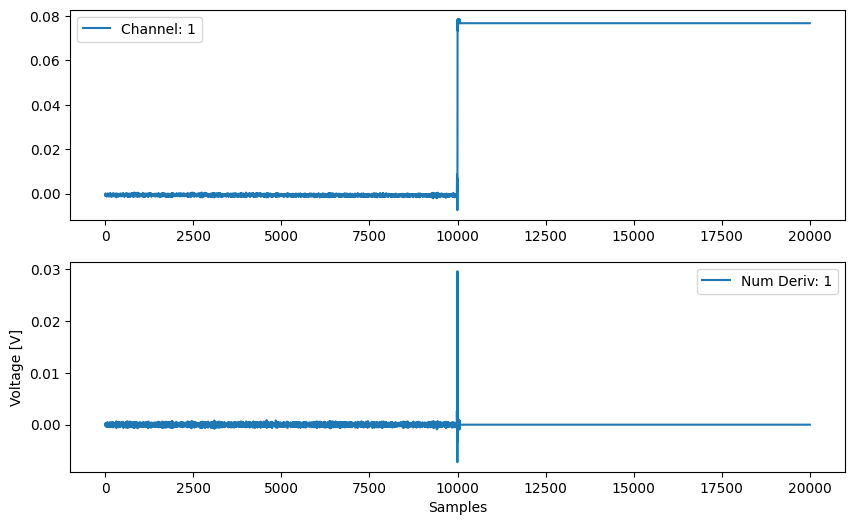

In [8]:
iEvent = 6
ICHANNEL = 6

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

y_waveform = out_data["channel"][iEvent, ICHANNEL, :]
x_samples = np.arange(len(y_waveform)) 
t = np.arange(y_waveform.shape[0])
dy_dt = np.gradient(y_waveform.astype(np.float64, copy=False), 1.0, edge_order=2)

ax1.plot(x_samples, y_waveform, label = f"Channel: {ICHANNEL+1}")
ax2.plot(t, dy_dt, label = f"Num Deriv: {ICHANNEL+1}")

ax1.legend()
ax2.legend()
plt.xlabel("Samples")
plt.ylabel("Voltage [V]")
plt.show()


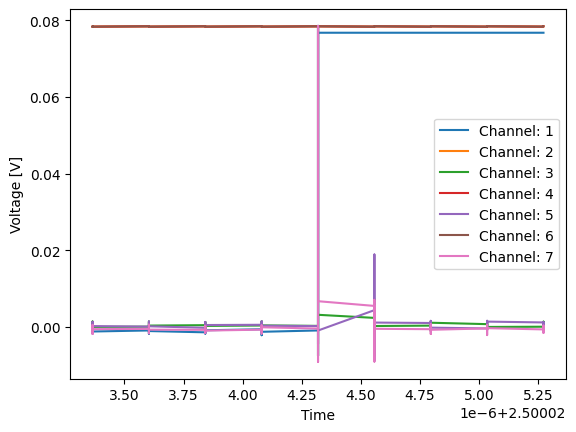

In [29]:
iEvent = 0
ICHANNEL = 6

for ICHANNEL in range(7):
    y_waveform = out_data["channel"][iEvent, ICHANNEL, :]
    # t = np.arange(y_waveform.shape[0])
    dy_dt = np.gradient(y_waveform.astype(np.float64, copy=False), 1.0, edge_order=2)

    plt.plot(t, y_waveform, label = f"Channel: {ICHANNEL+1}")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Voltage [V]")
plt.show()

In [33]:
t = time["time"]
t.shape

(1000, 1, 20002)

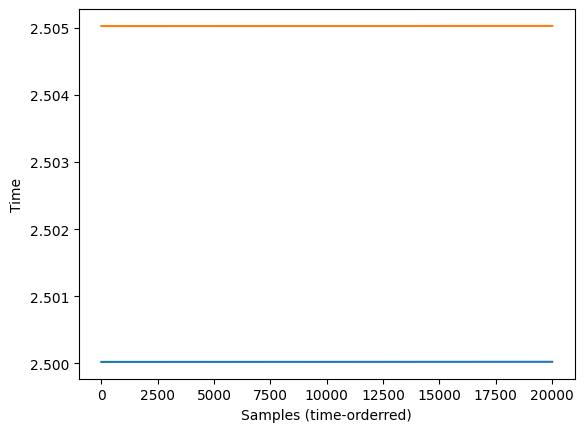

In [36]:
plt.figure()

plt.plot(time["time"][0, 0, :])
plt.plot(time["time"][2, 0, :])
plt.xlabel("Samples (time-orderred)")
plt.ylabel("Time")
plt.show()

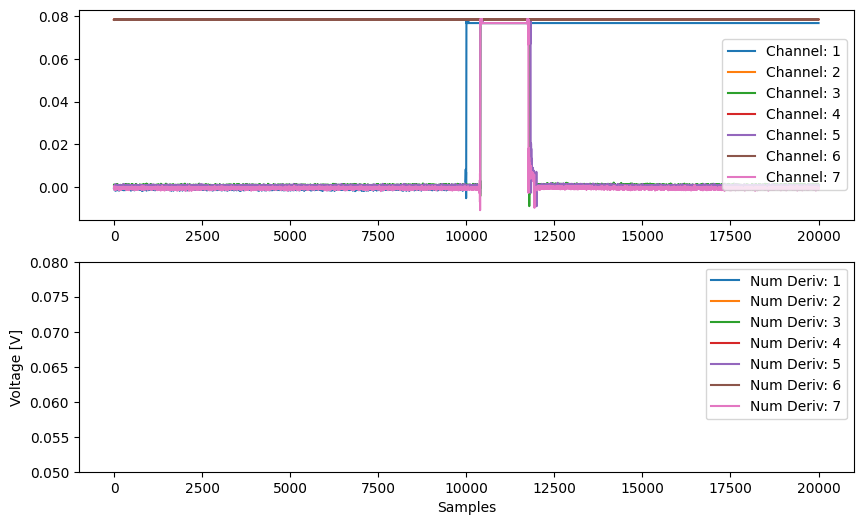

In [11]:

iEvent = 0
ICHANNEL = 0

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

for ICHANNEL in range(7):
    y_waveform = out_data["channel"][iEvent, ICHANNEL, :]
    t = np.arange(y_waveform.shape[0])
    dy_dt = np.gradient(y_waveform.astype(np.float64, copy=False), 1.0, edge_order=2)

    ax1.plot(x_samples, y_waveform, label = f"Channel: {ICHANNEL+1}")
    ax2.plot(t, dy_dt, label = f"Num Deriv: {ICHANNEL+1}")

ax1.legend()
ax2.legend()
plt.xlabel("Samples")
plt.ylabel("Voltage [V]")
plt.ylim([0.05, 0.08])
plt.savefig(f"{FIGURES_PATH}event{iEvent}_channel{ICHANNEL+1}.png")
plt.show()

In [22]:
out_data = get_data(power, idx)
mean_data = out_data["channel"].mean(axis=0)
# mean_data = out_data["channel"][2, :, :]
from scipy.signal import savgol_filter

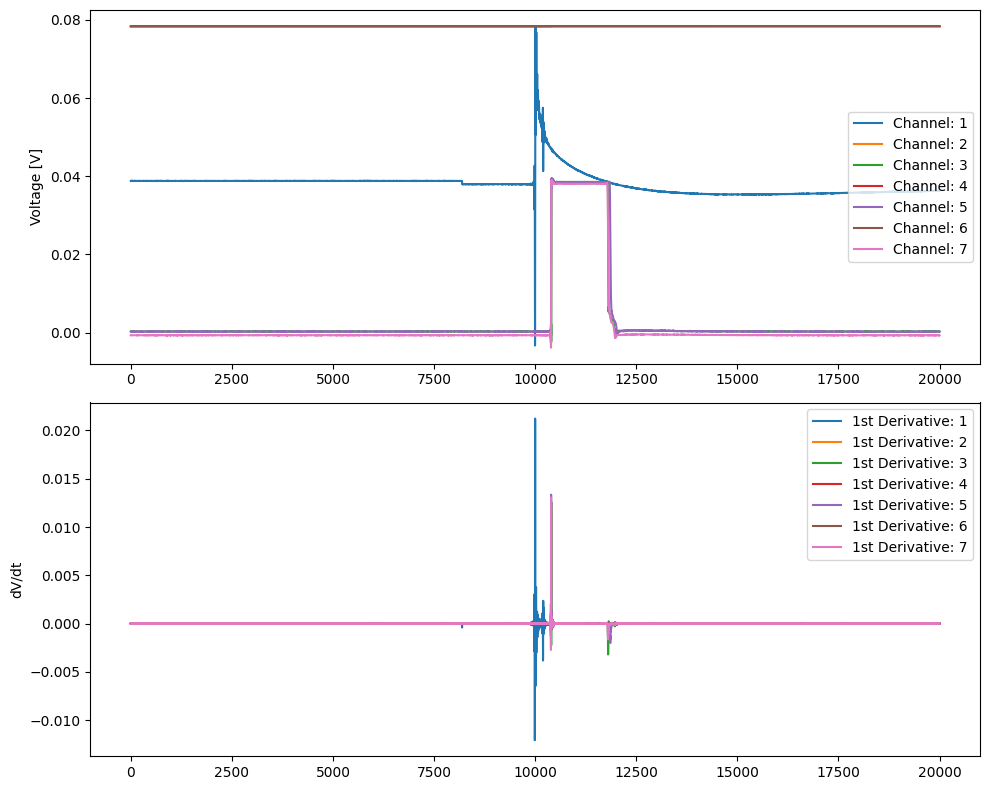

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for ICHANNEL in range(7):
    y_waveform = mean_data[ICHANNEL, :]
    # y_waveform = savgol_filter(y_waveform, window_length=70, polyorder=10)
    t = np.arange(y_waveform.shape[0])
    dy_dt = np.gradient(y_waveform.astype(np.float64, copy=False), 1.0, edge_order=2)

    ax1.plot(x_samples, y_waveform, label=f"Channel: {ICHANNEL+1}")
    ax2.plot(t, dy_dt, label=f"1st Derivative: {ICHANNEL+1}")

ax1.legend()
ax2.legend()

ax1.set_ylabel("Voltage [V]")
ax2.set_ylabel("dV/dt")
ax3.set_xlabel("Samples")

plt.tight_layout()
plt.show()


In [50]:
out_data = get_data(power, idx)
# mean_data = out_data["channel"].mean(axis=0)
mean_data = out_data["channel"][2, :, :]
#

In [51]:
def find_pulse_edges(ch, noise_window=100, noise_factor=5, peak_fraction=0.2):
    dy_dt = np.gradient(ch.astype(np.float64, copy=False), edge_order=2)

    baseline = dy_dt[:noise_window]
    sigma = np.std(baseline)

    thr_noise = noise_factor * sigma
    thr_peak  = peak_fraction * np.max(np.abs(dy_dt))

    thr_pos = max(thr_noise, thr_peak)     
    thr_neg = -max(thr_noise, thr_peak)    

    rise_candidates = np.where(dy_dt > thr_pos)[0]
    fall_candidates = np.where(dy_dt < thr_neg)[0]

    rise_idx, fall_idx = None, None
    if rise_candidates.size > 0:
        rise_idx = rise_candidates[0]  
    if fall_candidates.size > 0:
        fall_idx = fall_candidates[-1]

    return rise_idx, fall_idx, thr_pos, thr_neg


Channel: 1, Rise: 9998, Fall: None, Rise Thr: 0.005493864696472884, Fall Thr: -0.005493864696472884
Channel: 2, Rise: None, Fall: 20001, Rise Thr: 8.328027180176803e-05, Fall Thr: -8.328027180176803e-05
Channel: 3, Rise: 10398, Fall: 11808, Rise Thr: 0.006092358380556107, Fall Thr: -0.006092358380556107
Channel: 4, Rise: None, Fall: 20001, Rise Thr: 8.328027180176803e-05, Fall Thr: -8.328027180176803e-05
Channel: 5, Rise: 10392, Fall: 11862, Rise Thr: 0.005940293613821268, Fall Thr: -0.005940293613821268
Channel: 6, Rise: None, Fall: 20001, Rise Thr: 8.328027180176803e-05, Fall Thr: -8.328027180176803e-05
Channel: 7, Rise: 10388, Fall: 11803, Rise Thr: 0.006317665055394173, Fall Thr: -0.006317665055394173


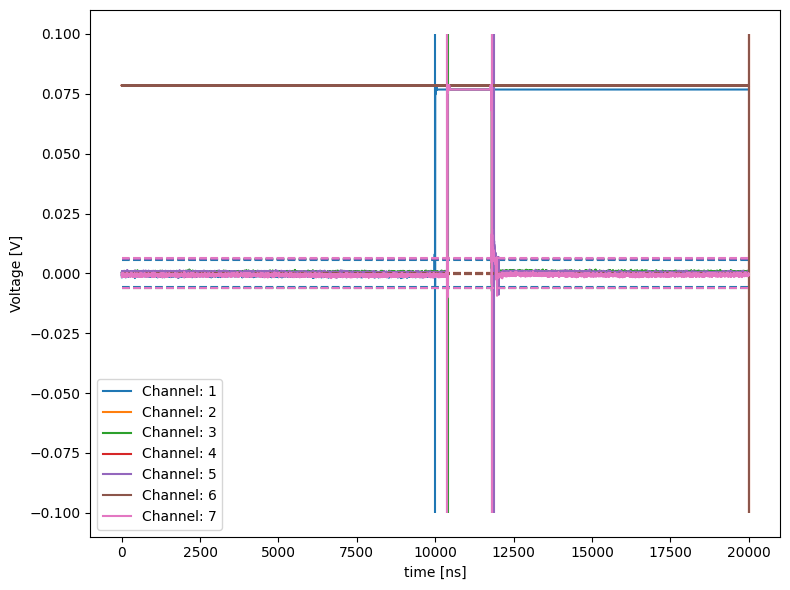

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
col = plt.get_cmap("tab10").colors
for ICHANNEL in range(7):
    y_waveform = mean_data[ICHANNEL, :]
    t = np.arange(y_waveform.shape[0])
    rise_idx, fall_idx, thr_pos, thr_neg = find_pulse_edges(y_waveform)
    print(f"Channel: {ICHANNEL+1}, Rise: {rise_idx}, Fall: {fall_idx}, Rise Thr: {thr_pos}, Fall Thr: {thr_neg}")

    color = col[ICHANNEL]
    ax.plot(x_samples, y_waveform, label=f"Channel: {ICHANNEL+1}")
    ax.vlines(x=rise_idx, ymin=-0.1, ymax=0.1, colors=color)
    ax.vlines(x=fall_idx, ymin=-0.1, ymax=0.1, colors=color)
    ax.hlines(y=thr_pos, xmin=np.min(x_samples), xmax=np.max(x_samples), colors=color, linestyles="dashed")
    ax.hlines(y=thr_neg, xmin=np.min(x_samples), xmax=np.max(x_samples), colors=color, linestyles="dashed")

ax.set_ylabel("Voltage [V]")
ax.set_xlabel("time [ns]")
ax.legend()
plt.tight_layout()
plt.show()

In [68]:
power_list = np.linspace(80, 95, 7)
ICHANNEL = 2

power_means = []
power_errs  = []
for power in power_list:
    print(f"Power: {power}%")
    converted_path = os.path.join(BASE_PATH, f"run_Power_{power}%", "converted")
    converted_files = glob.glob(os.path.join(converted_path, "*.root"))
    sorted_files = sorted(
            converted_files,
            key=lambda path: int(re.search(r'run(\d+)\.root', path).group(1))
        )
    
    per_event_means = []
    for data_path in tqdm(sorted_files, total=len(sorted_files)):
        with ur.open(data_path) as data_file:
            data = data_file["pulse"]
            out_data = data.arrays(["channel"], library="np")
            num_events = out_data["channel"].shape[0]
            for iEvent in range(num_events):
                y_waveform = out_data["channel"][iEvent, :, ICHANNEL]
                rise_idx, fall_idx, thr_pos, thr_neg = find_pulse_edges(y_waveform)

                roi = y_waveform[rise_idx:fall_idx]
                mean_roi = np.mean(roi)

                per_event_means.append(mean_roi)

    per_event_means = np.array(per_event_means)
    power_means.append(np.mean(per_event_means))
    power_errs.append(np.std(per_event_means) / np.sqrt(len(per_event_means)))
                


Power: 80.0%


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Power: 82.5%


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]


Power: 85.0%


100%|██████████| 15/15 [00:28<00:00,  1.90s/it]


Power: 87.5%


100%|██████████| 15/15 [00:29<00:00,  1.99s/it]


Power: 90.0%


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


Power: 92.5%


100%|██████████| 15/15 [00:28<00:00,  1.89s/it]


Power: 95.0%


100%|██████████| 15/15 [00:20<00:00,  1.33s/it]


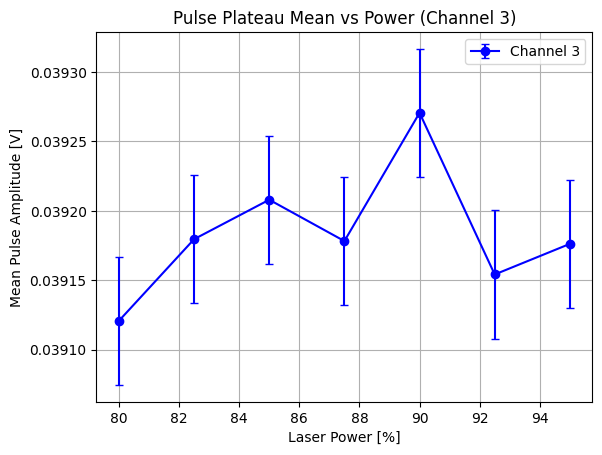

In [69]:
plt.errorbar(power_list, power_means, yerr=power_errs,
             fmt='o-', color='blue', capsize=3, label=f"Channel {ICHANNEL+1}")
plt.xlabel("Laser Power [%]")
plt.ylabel("Mean Pulse Amplitude [V]")
plt.title(f"Pulse Plateau Mean vs Power (Channel {ICHANNEL+1})")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(FIGURES_PATH, f"mean_vs_power_ch{ICHANNEL+1}.png"))
plt.show()